## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
goat = pd.read_csv('chronic_kidney_disease_full.csv')
goat.groupby('class')['class'].agg(['count'])

# Assigning a 1 to eveyone who has CKD
goat.loc[(goat['class'] == 'ckd'), 'class'] = 1

# Assigning a 0 to eveyone who does NOT have CKD
goat.loc[(goat['class'] == 'notckd'), 'class'] = 0



In [3]:
# Checking the number of missing values
print(goat.shape)
goat.isnull().sum()

(400, 25)


age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [4]:
# Creating Dummy variables for all categorical values in the dataframe
goat = pd.get_dummies(goat, drop_first=True )


In [5]:
# Checking to make sure that the data types don't include anymore objects
goat.dtypes

age            float64
bp             float64
sg             float64
al             float64
su             float64
bgr            float64
bu             float64
sc             float64
sod            float64
pot            float64
hemo           float64
pcv            float64
wbcc           float64
rbcc           float64
class            int64
rbc_normal       uint8
pc_normal        uint8
pcc_present      uint8
ba_present       uint8
htn_yes          uint8
dm_yes           uint8
cad_yes          uint8
appet_poor       uint8
pe_yes           uint8
ane_yes          uint8
dtype: object

In [6]:
# Creating a function to replace the NaN's with the mean value of the column
def replace_with_mean(x, mean):
    if np.isnan(x):
        return mean
    return x

In [7]:
# Applying that function to the Dataframe
def mean_col(df):
    df2 = df.copy()
    for col in df.columns:
        mean = df[col].mean()
        df2[col] = df[col].apply(lambda x: replace_with_mean(x, mean))
    return df2

In [8]:
goat = mean_col(goat)

In [9]:
# Creating DF for problem #21
have_ckd = goat.loc[(goat['class'] ==  1)]

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

In [10]:
# Looking at how the different features are correlated with the class value which is the dependent variable
goat.corr()[['class']].sort_values('class', ascending=False)

,class
class,1.000000
al,0.599238
htn_yes,0.590438
dm_yes,0.559060
bgr,0.401374
appet_poor,0.393341
pe_yes,0.375154
bu,0.372033
su,0.327812
ane_yes,0.325396


Answer: Hemoglobin levels, perhaps age, Packed Cell Volume

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

Based on the info above there are 1012 values missing from the dataset. Red Blood Cells, Red Blood Cell Count, White Blood Cell Count lead the way with 152, 131, and 106 missing values respectively. Potassium and sodium also are missing 88 and 87 values.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

Answer: This would be a bad idea for this dataset. There are only 400 total samples in this dataset if we removed every row where there was a missing value, we would be deleting over half of the data that we have avaiable to us. This would drastically reduce our statistical power and would render our predictions less valuable.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: Any of the catagorical data that is based on a subjective measure, like appetite could be influenced by the doctor or nurse or how the patient reports their appetite. If something is being recorded as normal vs. abnormal if they are right near the threshold and it is a judgement call on the part of the doctor or the nurse then that could have a large effect. 

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: You would tell every person that they have CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We optomized for false negatives. Meaning that we have no false negatives but lots of false negatives.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: You are telling lots of people who don't have CKD that they have it. So you are overdiagnosing patients, causing them unnecessary stress and anxiety and most likely charging them for treatments that they don't need.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: You tell everyone that they do not have CKD

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We optimized for false positives meaning that we have no false positives and lots of false negatives. 

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: We are telling people who have kidney disease that they don't. They will not seek treatment and potentially die. 

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [11]:
# Creating our variables to model
y=goat['class'] # Y variable will be class
goat_no_y = goat.drop(['class'], axis=1) # Creating a separate datafram without class


In [12]:
X = goat_no_y[goat_no_y.columns] # Setting that dataframe equal to our X values (independent variables)


In [13]:
# Checking the shapes to make sure that they match up for modeling
print(y.shape)
print(X.shape)


(400,)
(400, 24)


In [14]:
# Train test split our data using 30 percent for the test set and 70 percent for the training set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)
print(X_test.shape) # Double Checking the shapes again
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)


(120, 24)
(280, 24)
(120,)
(280,)


In [15]:
# Scaling the data because logistic regression is very sensitive to differences in the magnitude of data
ss = StandardScaler()
X_sc = ss.fit_transform(X_train)
test_sc = ss.transform(X_test)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [16]:
# Instantiate Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train) # Fit the model to the training set
print(f' coefficients: {logreg.coef_}') # Print out the coefficients
print('')
print(f' exponentiated coefficients: {np.exp(logreg.coef_)}') # Exponentiate the coefficients so that they can be interpreted
preds = logreg.predict(X_test) # Generating predictions using our test data
coef = np.exp(logreg.coef_) # Setting the exponentiated coefficients equal to a variable to use down below

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 coefficients: [[-1.76670053e-03  7.85901251e-02  6.50716843e-02  1.58018421e+00
   3.94678412e-01  3.16261700e-02 -3.02305577e-02  1.21287210e+00
   4.91697846e-02  2.06234043e-01 -1.09225554e+00 -1.87335449e-02
   4.02044436e-05 -5.28651437e-01 -1.93947707e+00 -4.20887697e-01
   4.05960250e-02  1.25040625e-02  6.07547668e-01  5.26678914e-01
   2.84587724e-02  5.12765928e-01  5.62041811e-01  1.61031836e-01]]

 exponentiated coefficients: [[0.99823486 1.08176084 1.06723553 4.85585022 1.48390691 1.03213159
  0.97022182 3.36313003 1.05039868 1.22904082 0.335459   0.98144084
  1.00004021 0.58939928 0.14377912 0.65646382 1.04143131 1.01258257
  1.83592358 1.69329937 1.02886759 1.66990365 1.75425069 1.17472237]]


In [17]:
preds # The array of predicted values using the Logistic Regression model. 

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [18]:
# Creating a Dataframe that has the values of the coefficients of the model sorted from highest to lowest
coef_df = pd.DataFrame({'variables':X_train.columns})
coef = np.squeeze(coef)
coe = pd.DataFrame({'ß - Beta': coef})
coef_df = pd.concat([coef_df, coe], axis=1)
values = pd.DataFrame(X_train, index=list(range(0,140280)), columns=coef_df['variables'])
values['class'] = y
coef_df.sort_values('ß - Beta', ascending=False)


,variables,ß - Beta
3,al,4.855850
7,sc,3.363130
18,htn_yes,1.835924
22,pe_yes,1.754251
19,dm_yes,1.693299
21,appet_poor,1.669904
4,su,1.483907
9,pot,1.229041
23,ane_yes,1.174722
1,bp,1.081761


In [19]:
# Use gridsearch CV with Lasso and Ridge Penalty to determine 
gs_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

lr_gridsearch = GridSearchCV(
    LogisticRegression(solver='liblinear'),
    gs_params,
    cv=7,
    n_jobs=4,
    verbose=1,
    return_train_score=False
)

In [20]:
# Fitting the girdsearch to our training data
lr_gridsearch = lr_gridsearch.fit(X_train, y_train)

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    5.2s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
# Seeing what the best score we got on our training data was
lr_gridsearch.best_score_

0.9892857142857143

In [22]:
# Checking to see what penalty (in this case Lasso) and what value of C in this case 0.24 resulted in our best score
lr_gridsearch.best_params_

{'C': 0.24244620170823283, 'penalty': 'l1'}

In [23]:
best_lr = lr_gridsearch.best_estimator_
best_lr

LogisticRegression(C=0.24244620170823283, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
# Checking to see what the best score is with the testing data
best_lr.score(X_test, y_test)

0.9916666666666667

In [25]:
lr_gridsearch.cv_results_

{'mean_fit_time': array([0.00723539, 0.2270597 , 0.00825391, 0.00619524, 0.00420124,
        0.00721553, 0.00370336, 0.00872656, 0.00547062, 0.00780681,
        0.00742183, 0.01010043, 0.00507062, 0.00575461, 0.00656206,
        0.00587385, 0.00548322, 0.01055356, 0.00526067, 0.00651905,
        0.00563182, 0.00771703, 0.0078076 , 0.00694997, 0.00718924,
        0.00854414, 0.00841355, 0.00925551, 0.01111494, 0.0064965 ,
        0.00905303, 0.00690552, 0.00778157, 0.00653325, 0.00794431,
        0.00903906, 0.0073374 , 0.00868303, 0.01123353, 0.00940807,
        0.01168575, 0.00595457, 0.0099424 , 0.00691829, 0.00955173,
        0.00876985, 0.01099723, 0.01009137, 0.01388672, 0.00613144,
        0.00963664, 0.00822667, 0.01027472, 0.0083282 , 0.01029829,
        0.008547  , 0.01128725, 0.00720225, 0.01608242, 0.00833375,
        0.01200727, 0.00846747, 0.0098849 , 0.00887551, 0.00925524,
        0.00767068, 0.01402998, 0.01092996, 0.00987499, 0.00769687,
        0.01510365, 0.00863957,

In [26]:
# Putting the results of the Gridsearch into a Datafram so that we can use it to graph. 
gs_df = pd.DataFrame(lr_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_penalty'] == 'l1']

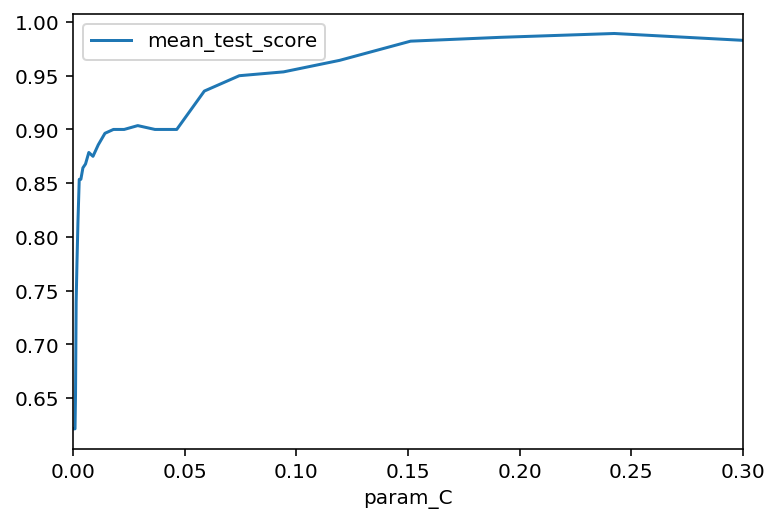

In [27]:
# Showing a graph of the mean test score generated by the different values of C. You can see that it peaks around 0.24.
gs_df.plot(x='param_C', y='mean_test_score');
plt.xlim(0, 0.3);

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

We saw above that the coefficient for blood pressure was 1.08176084. This means that for a 1 unit increase in blood pressure the patient is 1.08 times more likely to have cronic kidney disease

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

We say above that the coefficient of the dummy variable anemia was 1.17472237. This means that if a person was suffering from anemia that they were 1.175 times as likely to have cronic kidney disease.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: Logistic regression is easily interpreted. You are measing something that makes sense a binary outcome that can be classified as a success or failure. It is also probabilistic so it gives you an understandable output - how likely something is to occur and how an independent variable influences the likelihood of that binary outcome occuring. 

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [28]:
# Creating a confusion matrix with our true Y test values and our predicted values from our model
confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

array([[43,  1],
       [ 0, 76]])

In [29]:
# We can see that we have 43 True Negatives, 1 False Postive, 0 False Negatives and 76 true positives.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


True Negatives: 43
False Positives: 1
False Negatives: 0
True Positives: 76


In [30]:
# Calculating the specificity, Recall, Precision and Accuracy of this model
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity/Recall: {round(sens,4)}')

prec = tp / (fn + tp)

print(f'Precision: {round(prec,4)}')

acc = (tp + tn) / (tp + tn + fp + fn)

print(f'Accuracy: {round(acc,4)}')


Specificity: 0.9773
Sensitivity/Recall: 1.0
Precision: 1.0
Accuracy: 0.9917


In [31]:
# Creating a list of the predicted probabilities for our test set so we can graph them below
pred_proba = [i[1] for i in logreg.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

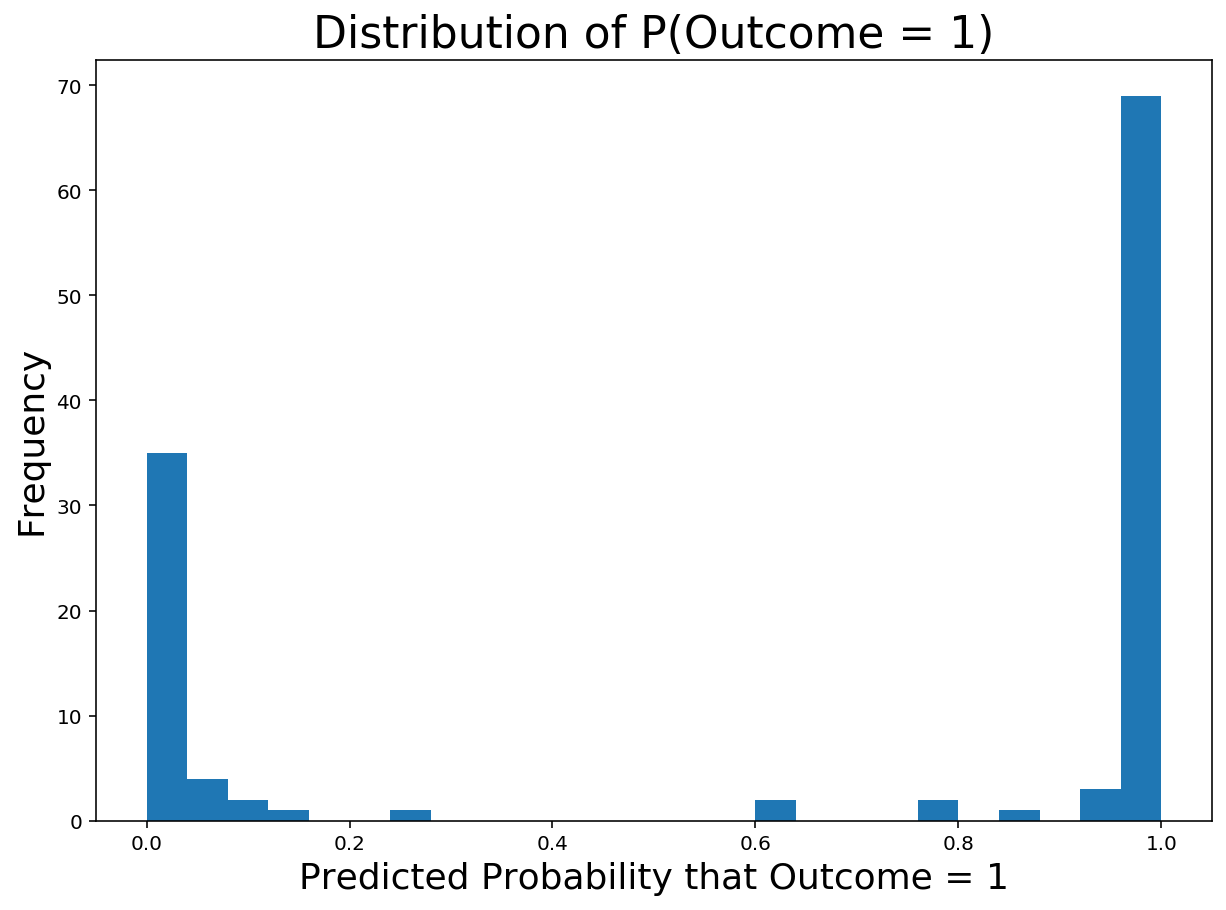

In [32]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);


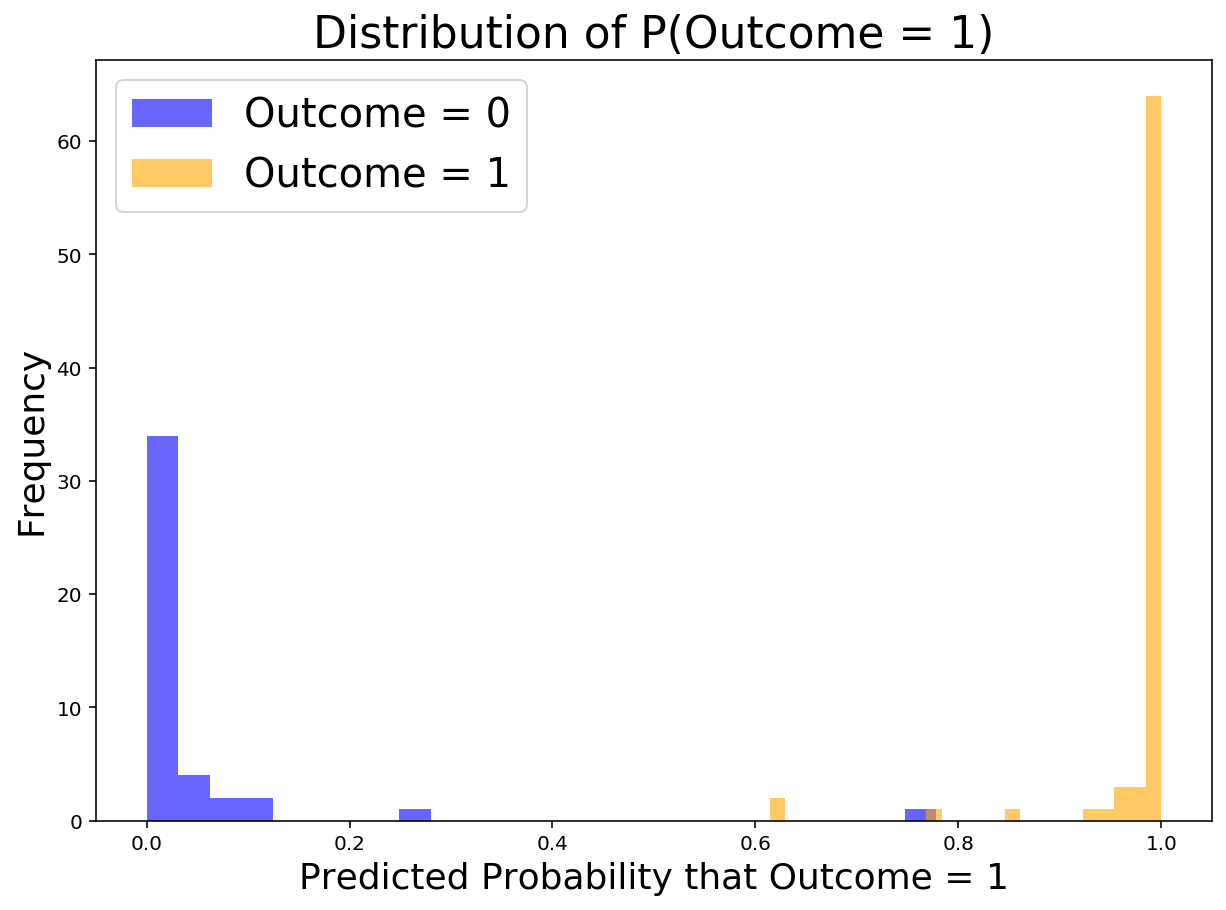

In [33]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

Answer:

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: In the health field unbalance classes will generally lead to false negatives and not false positives. And we are attempting to identify those ooutliers. We care mroe about fining the positives then identifying negatives at a high rate. 

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [34]:
# Datafram we created from above containing only people with CKD
have_ckd.count()

age            250
bp             250
sg             250
al             250
su             250
bgr            250
bu             250
sc             250
sod            250
pot            250
hemo           250
pcv            250
wbcc           250
rbcc           250
class          250
rbc_normal     250
pc_normal      250
pcc_present    250
ba_present     250
htn_yes        250
dm_yes         250
cad_yes        250
appet_poor     250
pe_yes         250
ane_yes        250
dtype: int64

In [35]:
have_ckd # Datafram containing only people who have CKD, Creating a random datafram from this one that contains 200,000
really_have_ckd = have_ckd.sample(n=200_000, replace=True)

In [36]:
all_goats = pd.concat([goat, really_have_ckd], axis=0)

In [37]:
all_goats

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class,rbc_normal,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.000000,80.000000,1.020000,1.000000,0.000000,121.000000,36.000000,1.200000,137.528754,4.627244,15.400000,44.000000,7800.000000,5.200000,1,0,1,0,0,1,1,0,0,0,0
1,7.000000,50.000000,1.020000,4.000000,0.000000,148.036517,18.000000,0.800000,137.528754,4.627244,11.300000,38.000000,6000.000000,4.707435,1,0,1,0,0,0,0,0,0,0,0
2,62.000000,80.000000,1.010000,2.000000,3.000000,423.000000,53.000000,1.800000,137.528754,4.627244,9.600000,31.000000,7500.000000,4.707435,1,1,1,0,0,0,1,0,1,0,1
3,48.000000,70.000000,1.005000,4.000000,0.000000,117.000000,56.000000,3.800000,111.000000,2.500000,11.200000,32.000000,6700.000000,3.900000,1,1,0,1,0,1,0,0,1,1,1
4,51.000000,80.000000,1.010000,2.000000,0.000000,106.000000,26.000000,1.400000,137.528754,4.627244,11.600000,35.000000,7300.000000,4.600000,1,1,1,0,0,0,0,0,0,0,0
5,60.000000,90.000000,1.015000,3.000000,0.000000,74.000000,25.000000,1.100000,142.000000,3.200000,12.200000,39.000000,7800.000000,4.400000,1,0,0,0,0,1,1,0,0,1,0
6,68.000000,70.000000,1.010000,0.000000,0.000000,100.000000,54.000000,24.000000,104.000000,4.000000,12.400000,36.000000,8406.122449,4.707435,1,0,1,0,0,0,0,0,0,0,0
7,24.000000,76.469072,1.015000,2.000000,4.000000,410.000000,31.000000,1.100000,137.528754,4.627244,12.400000,44.000000,6900.000000,5.000000,1,1,0,0,0,0,1,0,0,1,0
8,52.000000,100.000000,1.015000,3.000000,0.000000,138.000000,60.000000,1.900000,137.528754,4.627244,10.800000,33.000000,9600.000000,4.000000,1,1,0,1,0,1,1,0,0,0,1
9,53.000000,90.000000,1.020000,2.000000,0.000000,70.000000,107.000000,7.200000,114.000000,3.700000,9.500000,29.000000,12100.000000,3.700000,1,0,0,1,0,1,1,0,1,0,1


In [38]:
# After concatinating the DF's we have 200,250 people with CKD and 150 people without
all_goats.groupby('class')['class'].agg(['count'])

,count
class,
0,150
1,200250


### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [39]:
y = all_goats['class']
all_goats.drop(['class'], axis=1, inplace=True)
X=all_goats[all_goats.columns]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(60120, 24)
(140280, 24)
(60120,)
(140280,)


In [41]:
# Instantiate Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train) # Fit the model to the training set
print(f' coefficients: {logreg.coef_}') # Print out the coefficients
print('')
print(f' exponentiated coefficients: {np.exp(logreg.coef_)}') # Exponentiate the coefficients so that they can be interpreted
preds = logreg.predict(X_test)
coef = np.exp(logreg.coef_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 coefficients: [[-4.58292322e-02  7.71854547e-02  8.90698107e-02  2.29578047e+00
   3.77673869e-01  4.13888822e-02 -6.65210804e-02  2.41151327e+00
   2.00899394e-01  4.12437170e-01 -1.70101536e+00 -6.06544910e-02
   9.18028805e-05 -1.96462212e+00 -4.67153141e+00 -4.18094892e-01
   7.07653738e-02  1.21458829e-02  1.81302097e+00  1.95812779e+00
   4.50265801e-02  5.83535172e-01  6.18747351e-01  1.45804730e-01]]

 exponentiated coefficients: [[9.55205067e-01 1.08024239e+00 1.09315697e+00 9.93218472e+00
  1.45888708e+00 1.04225734e+00 9.35643192e-01 1.11508226e+01
  1.22250177e+00 1.51049464e+00 1.82498129e-01 9.41148359e-01
  1.00009181e+00 1.40208858e-01 9.35792774e-03 6.58299758e-01
  1.07332937e+00 1.01221994e+00 6.12893484e+00 7.08604808e+00
  1.04605566e+00 1.79236356e+00 1.85660092e+00 1.15697024e+00]]


In [42]:
# How our model scored on our testing data
logreg.score(X_test, y_test)

0.9998669328010645

In [43]:
confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

array([[   48,     8],
       [    0, 60064]])

In [44]:
# We can see that we have 48 True Negatives, 8 False Postive, 0 False Negatives and 60,064 true positives.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


True Negatives: 48
False Positives: 8
False Negatives: 0
True Positives: 60064


In [45]:
# Calculating the specificity, Recall, Precision and Accuracy of this model

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

sens = tp / (tp + fn)

print(f'Sensitivity/Recall: {round(sens,4)}')

prec = tp / (fn + tp)

print(f'Precision: {round(prec,4)}')

acc = (tp + tn) / (tp + tn + fp + fn)

print(f'Accuracy: {round(acc,4)}')

Specificity: 0.8571
Sensitivity/Recall: 1.0
Precision: 1.0
Accuracy: 0.9999


---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

So because we have such an unbalanced data set we are at risk for have specificity issues. We could end up with a lot more false positives than before. However if our only goal is to prevent false negatives because this has to do with a medical problem, and the cost of a false postive isn't very high then we may be ok with this risk. It is really going to depend on what you are measuring if you have ussues with an unbalanced data set. 